%pip install spacy textblob swifter

In [26]:
# Import necessary libraries
try:
    import json
    import os
    import pandas as pd
    import numpy as np
    import spacy
    import swifter  # For applying functions in a fast and efficient way
    
    # Visualization libraries
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Text processing libraries
    import string
    from tqdm import tqdm  # For progress bars
    from textblob import TextBlob
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    import re
    
    # Machine learning libraries
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as IMBPipeline
    from imblearn.under_sampling import RandomUnderSampler
    
    # Custom transformers for pipeline
    from sklearn.preprocessing import FunctionTransformer
    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.pipeline import FeatureUnion
    from sklearn.feature_extraction import DictVectorizer

    # Setting seaborn theme for better visuals
    sns.set_theme(style="whitegrid")

    # Enabling progress_apply for pandas series via tqdm
    tqdm.pandas()

# Catching and printing any exception that occurs during the import process
except Exception as e:
    print(f"Error : {e}")

In [27]:
# Improved function to download and verify necessary NLTK resources
def download_nltk_resources():
    # Specifying the NLTK resources required for various NLP tasks
    resources = ['punkt', 'stopwords', 'averaged_perceptron_tagger', 'wordnet']  # Needed for tokenization, stopwords removal, POS tagging, and lemmatization respectively

    # Iterating over each resource to check its presence, and download if missing
    for resource in resources:
        try:
            # Check if the resource is already downloaded to avoid re-downloading
            nltk.data.find(f'tokenizers/punkt/{resource}.pickle')
        except LookupError:
            # Resource not found; proceed to download
            nltk.download(resource, quiet=True)  # quiet=True suppresses the output to keep the log cleaner
            print(f'NLTK resource "{resource}" downloaded.')

    # Notification upon successful verification or download of all resources
    print('All required NLTK resources are ready.')
'''
	- This code is copied from my previous college project. It is called Lazy Loading NLTK Resources. 
	- The idea behind it was that we don't need to download all the resources at once.
	- We can download them as and when needed.
	- This way, we can save time and space by downloading only the necessary resources.
'''

# Initiating the download and verification of NLTK resources
download_nltk_resources()

NLTK resource "punkt" downloaded.
NLTK resource "stopwords" downloaded.
NLTK resource "averaged_perceptron_tagger" downloaded.
NLTK resource "wordnet" downloaded.
All required NLTK resources are ready.


In [28]:
# Function to load and preprocess the dataset for Task 1
def load_t1_df(filename):
    # Define the columns to be loaded from the file
    columns = ['par_id', 'paragraph', 'has_entity', 'lexicon_count', 'difficult_words', 'last_editor_gender', 'category']
    # Load the dataset with specified columns
    df = pd.read_csv(filename, usecols=columns)
    # Add an 'index' column that starts from 1
    df['index'] = df.index + 1
    # Check if the DataFrame is empty and print a message accordingly
    if not df.empty:
        print(f"{df.shape[0]} rows and {df.shape[1]} columns (without 'text_clarity') loaded successfully for Task 1, including newly added 'index' column.")
    else:
        print("The dataset is empty.")
    return df

# Function to load and preprocess the dataset for Task 2
def load_t2_df(filename):
    columns = ['par_id', 'paragraph', 'has_entity', 'lexicon_count', 'difficult_words', 'last_editor_gender', 'category', 'text_clarity']
    # Load the dataset with specified columns
    df = pd.read_csv(filename, usecols=columns)
    # Add an 'index' column that starts from 1
    df['index'] = df.index + 1
    # Check if the DataFrame is empty and print a message accordingly
    if not df.empty:
        print(f"{df.shape[0]} rows and {df.shape[1]} columns loaded successfully for Task 2, including newly added 'index' column.")
    else:
        print("The dataset is empty.")
    return df

'''
	- Function usage: df = load_t1_df('filename_with_path')
	- Replace `filename_with_path` with your original value.
'''

df = load_t1_df('../Datasets/dataset.csv')

9347 rows and 8 columns (without 'text_clarity') loaded successfully for Task 1, including newly added 'index' column.


In [29]:
def clean_df(df):
    # Print initial shape and missing values count
    print("-" * 55)
    print(f'Initial shape: {df.shape}. Checking for missing values...')
    missing_values_initial = df.isnull().sum()
    print(missing_values_initial)
    print("-" * 55)

    # Remove rows with missing values
    df_cleaned = df.dropna(subset=df.columns.difference(['text_clarity']))
    print('Removing rows with missing values...')
    print(missing_values_initial[missing_values_initial > 0])  # Print only columns with missing values

    # Print shape after removal and verify no missing values
    print("-" * 55)
    print(f'Updated shape: {df_cleaned.shape}. Verifying no missing values remain...')
    missing_values_final = df_cleaned.isnull().sum()
    print(missing_values_final)
    print("-" * 55)

    return df_cleaned

'''
	- Function usage: df = clean_df(df)
	- Replace `df` with your original DataFrame.
'''

df = clean_df(df)

-------------------------------------------------------
Initial shape: (9347, 8). Checking for missing values...
par_id                 0
paragraph              0
has_entity             0
lexicon_count          0
difficult_words       18
last_editor_gender     0
category              61
index                  0
dtype: int64
-------------------------------------------------------
Removing rows with missing values...
difficult_words    18
category           61
dtype: int64
-------------------------------------------------------
Updated shape: (9268, 8). Verifying no missing values remain...
par_id                0
paragraph             0
has_entity            0
lexicon_count         0
difficult_words       0
last_editor_gender    0
category              0
index                 0
dtype: int64
-------------------------------------------------------


In [30]:
def process_df(df):
    # Standardize 'category' column to lowercase
    print("-" * 55)
    print('Checking for unique values in the "category" column:')
    print(df['category'].unique())
    df['category'] = df['category'].str.lower()
    print('\nFixed the case of the "category" column, unique values now:')
    print(df['category'].unique())
    print("-" * 55)

    # Remove rows where 'has_entity' column has 'data missing'
    print("-" * 55)
    print('Checking for unique values in the "has_entity" column:')
    print(df['has_entity'].unique())
    df = df[df['has_entity'] != 'data missing']
    print('\nRemoved rows with "data missing" in the "has_entity" column, unique values now:')
    print(df['has_entity'].unique())
    print("-" * 55)

    return df

'''
	- Function usage: df = process_df(df)
	- Replace `df` with your original DataFrame.
'''

df = process_df(df)

-------------------------------------------------------
Checking for unique values in the "category" column:
['biographies' 'artificial intelligence' 'programming' 'philosophy'
 'movies about artificial intelligence' 'Philosophy' 'Programming'
 'Artificial intelligence' 'Biographies'
 'Movies about artificial intelligence']

Fixed the case of the "category" column, unique values now:
['biographies' 'artificial intelligence' 'programming' 'philosophy'
 'movies about artificial intelligence']
-------------------------------------------------------
-------------------------------------------------------
Checking for unique values in the "has_entity" column:
['ORG_YES_PRODUCT_NO_PERSON_YES_' 'ORG_YES_PRODUCT_NO_PERSON_NO_'
 'ORG_NO_PRODUCT_YES_PERSON_NO_' 'ORG_YES_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRODUCT_NO_PERSON_NO_' 'ORG_NO_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRODUCT_NO_PERSON_YES_' 'ORG_YES_PRODUCT_YES_PERSON_NO_'
 'data missing']

Removed rows with "data missing" in the "has_entity" co

In [31]:
# Transform the "has_entity" column into three binary columns for entity types
def split_entity_column(df):
    # Create binary columns based on the presence of specific entity types in the 'has_entity' column
    df['ORG'] = df['has_entity'].apply(lambda x: 'ORG_YES' in x).astype(int)
    df['PRODUCT'] = df['has_entity'].apply(lambda x: 'PRODUCT_YES' in x).astype(int)
    df['PERSON'] = df['has_entity'].apply(lambda x: 'PERSON_YES' in x).astype(int)

    # Display the first few rows to verify the newly added binary columns alongside the 'has_entity' column
    print("-" * 55)
    print("Preview of the 'has_entity' column and the new binary columns:")
    print(df[['has_entity', 'ORG', 'PRODUCT', 'PERSON']].head())
    print("-" * 55)

    return df

'''
	- Function usage: df = split_entity_column(df)
	- Replace `df` with your original DataFrame.
'''

df = split_entity_column(df)


-------------------------------------------------------
Preview of the 'has_entity' column and the new binary columns:
                        has_entity  ORG  PRODUCT  PERSON
0   ORG_YES_PRODUCT_NO_PERSON_YES_    1        0       1
1    ORG_YES_PRODUCT_NO_PERSON_NO_    1        0       0
2    ORG_YES_PRODUCT_NO_PERSON_NO_    1        0       0
3    ORG_NO_PRODUCT_YES_PERSON_NO_    0        1       0
4  ORG_YES_PRODUCT_YES_PERSON_YES_    1        1       1
-------------------------------------------------------


In [32]:
def clean_text(text):
    # Remove punctuation marks and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_column(df, column_name):
    # Ensure the column exists in the DataFrame
    if column_name in df.columns:
        unclean = df[column_name]
        df[column_name + '_cleaned'] = df[column_name].apply(clean_text)
        clean = df[column_name + '_cleaned']
        print("-"*55)
        print("Original paragraph:\n", unclean.iloc[0])
        print("\nCleaned paragraph:\n", clean.iloc[0])
        print("-"*55)
    else:
        print(f"The column '{column_name}' does not exist in the DataFrame.")
    return df

'''
	- Function usage: df = clean_column(df, 'paragraph')
	- Replace `paragraph` with your original value.
'''

df = clean_column(df, 'paragraph')

-------------------------------------------------------
Original paragraph:
 Ramsay was born in Glasgow on 2 October 1852. He was a nephew of the geologist Sir Andrew Ramsay. His father, William, Sr., was a civil engineer. His mother was Catherine Robertson. He studied at Glasgow Academy, at the University of Glasgow and at University of Tubingen in Germany. 

Cleaned paragraph:
 Ramsay was born in Glasgow on October He was a nephew of the geologist Sir Andrew Ramsay His father William Sr was a civil engineer His mother was Catherine Robertson He studied at Glasgow Academy at the University of Glasgow and at University of Tubingen in Germany
-------------------------------------------------------


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9244 entries, 0 to 9346
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   par_id              9244 non-null   int64  
 1   paragraph           9244 non-null   object 
 2   has_entity          9244 non-null   object 
 3   lexicon_count       9244 non-null   int64  
 4   difficult_words     9244 non-null   float64
 5   last_editor_gender  9244 non-null   object 
 6   category            9244 non-null   object 
 7   index               9244 non-null   int64  
 8   ORG                 9244 non-null   int64  
 9   PRODUCT             9244 non-null   int64  
 10  PERSON              9244 non-null   int64  
 11  paragraph_cleaned   9244 non-null   object 
dtypes: float64(1), int64(6), object(5)
memory usage: 938.8+ KB


In [34]:
# Tokenize each paragraph and store the tokens in a new column 'tokenized_paragraph'
def tokenize_column(df, column_name):
    # Ensure the column exists in the DataFrame
    if column_name in df.columns:
        clean = df[column_name]
        df[column_name + '_tokenized'] = df[column_name].apply(lambda x: word_tokenize(x))
        tokenized = df[column_name + '_tokenized']
        print("-"*55)
        print("Cleaned paragraph:\n", clean.iloc[0])
        print("\nTokenized paragraph:\n", tokenized.iloc[0])
        print("-"*55)
    else:
        print(f"The column '{column_name}' does not exist in the DataFrame.")
    return df

'''
	- Function usage: df = clean_column(df, 'paragraph')
	- Replace `paragraph` with your original value.
'''

df = tokenize_column(df, 'paragraph_cleaned')

-------------------------------------------------------
Cleaned paragraph:
 Ramsay was born in Glasgow on October He was a nephew of the geologist Sir Andrew Ramsay His father William Sr was a civil engineer His mother was Catherine Robertson He studied at Glasgow Academy at the University of Glasgow and at University of Tubingen in Germany

Tokenized paragraph:
 ['Ramsay', 'was', 'born', 'in', 'Glasgow', 'on', 'October', 'He', 'was', 'a', 'nephew', 'of', 'the', 'geologist', 'Sir', 'Andrew', 'Ramsay', 'His', 'father', 'William', 'Sr', 'was', 'a', 'civil', 'engineer', 'His', 'mother', 'was', 'Catherine', 'Robertson', 'He', 'studied', 'at', 'Glasgow', 'Academy', 'at', 'the', 'University', 'of', 'Glasgow', 'and', 'at', 'University', 'of', 'Tubingen', 'in', 'Germany']
-------------------------------------------------------


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9244 entries, 0 to 9346
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   par_id                       9244 non-null   int64  
 1   paragraph                    9244 non-null   object 
 2   has_entity                   9244 non-null   object 
 3   lexicon_count                9244 non-null   int64  
 4   difficult_words              9244 non-null   float64
 5   last_editor_gender           9244 non-null   object 
 6   category                     9244 non-null   object 
 7   index                        9244 non-null   int64  
 8   ORG                          9244 non-null   int64  
 9   PRODUCT                      9244 non-null   int64  
 10  PERSON                       9244 non-null   int64  
 11  paragraph_cleaned            9244 non-null   object 
 12  paragraph_cleaned_tokenized  9244 non-null   object 
dtypes: float64(1), int64(6)

-------------------------------------------------------
Imbalanced Category Distribution:
category
biographies                             2940
philosophy                              2588
programming                             1982
artificial intelligence                 1568
movies about artificial intelligence     166
Name: count, dtype: int64
-------------------------------------------------------


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f69e42061f0>
Traceback (most recent call last):
  File "/opt/conda/envs/COMP1804-AML/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    def switch_backend(self, backend):
  File "/opt/conda/envs/COMP1804-AML/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    # Controllers for the libraries that we'll look for in the loaded libraries.
  File "/opt/conda/envs/COMP1804-AML/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    """Return an instance of this class that can be used as a decorator"""
  File "/opt/conda/envs/COMP1804-AML/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    num_threads[user_api] = limit
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <f

-------------------------------------------------------
Balanced Category Distribution:
balanced_category
artificial intelligence                 2940
biographies                             2940
movies about artificial intelligence    2940
philosophy                              2940
programming                             2940
Name: count, dtype: int64
-------------------------------------------------------


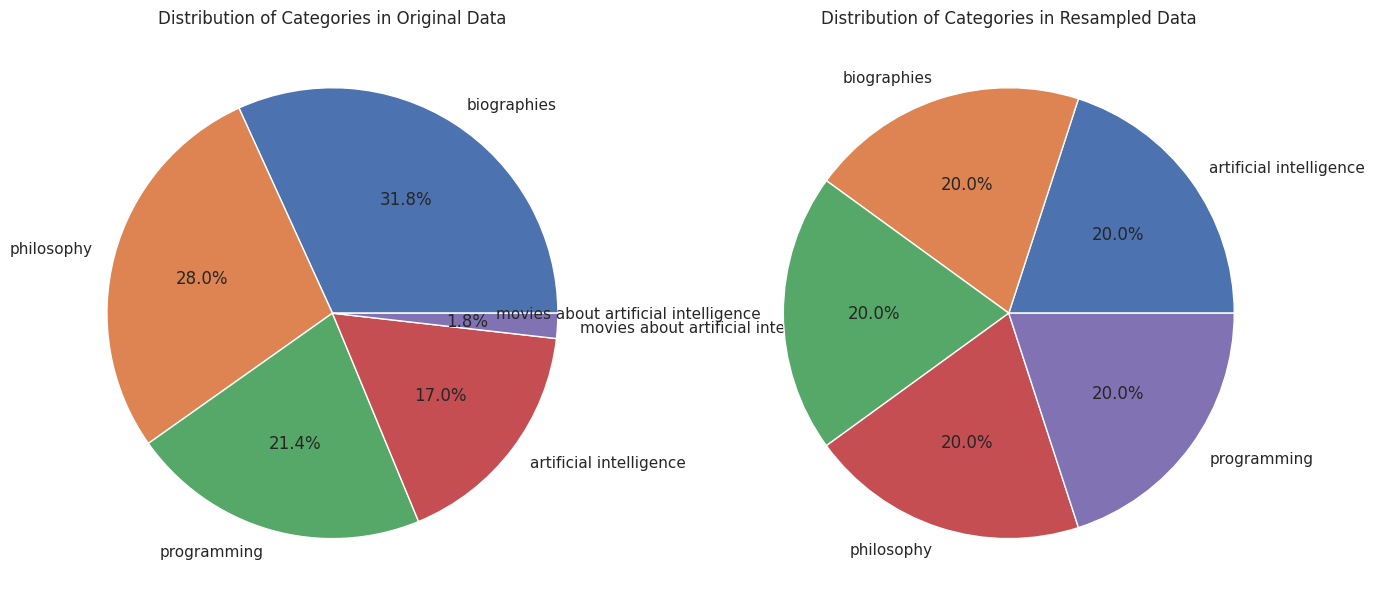

In [36]:
# Displaying the imbalanced category distribution
from torch import mode


print("-"*55)
print("Imbalanced Category Distribution:")
print(df['category'].value_counts())
print("-"*55)

# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['category'])
df['paragraph_cleaned_tokenized_str'] = df['paragraph_cleaned_tokenized'].apply(lambda x: ' '.join(x))
X_text = df['paragraph_cleaned']

# Vectorizing the text data
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vectorized = tfidf_vectorizer.fit_transform(X_text)

def get_measure_value(class_counts, measure_type):
    if measure_type == 'mean':
        return class_counts.mean()
    elif measure_type == 'median':
        return class_counts.median()
    elif measure_type == 'mode':
        return class_counts.mode()[0] if len(class_counts.mode()) > 0 else None
    elif measure_type == 'max':
        return class_counts.max()
    else:
        raise ValueError(f"Invalid measure_type: {measure_type}")

# Calculate the count of instances in each class
class_counts = df['category'].value_counts()

# TODO: Mean/median/mode/max calculation result
# Set the measure type according to your need
measure_type = 'max'  # Choose median or 'mean', 'mode', 'max'

# Get the measure value
set_count = get_measure_value(class_counts, measure_type)

# Define minority_classes as those with counts less than the set_count
minority_classes = class_counts[class_counts < set_count].index.tolist()
majority_classes = class_counts[class_counts >= set_count].index.tolist()

# Encode class names to their numeric labels
encoded_minority_classes = encoder.transform(minority_classes)
encoded_majority_classes = encoder.transform(majority_classes)

# Create sampling strategy dictionaries using encoded labels
sampling_strategy_over_encoded = {label: int(set_count) for label in encoded_minority_classes}
sampling_strategy_under_encoded = {label: int(set_count) for label in encoded_majority_classes}

# Create the resampling pipeline with adjusted strategies
resampling_pipeline = IMBPipeline([
    ('smote', SMOTE(sampling_strategy=sampling_strategy_over_encoded, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=sampling_strategy_under_encoded, random_state=42))
])

# Proceed with resampling
X_resampled, y_resampled = resampling_pipeline.fit_resample(X_vectorized, y_encoded)

# Decode the labels back to original category names after resampling
y_resampled_decoded = encoder.inverse_transform(y_resampled)

# Create a DataFrame to display the before and after category distribution
resampled_df = pd.DataFrame(y_resampled_decoded, columns=['balanced_category'])

print("-"*55)
print("Balanced Category Distribution:")
print(resampled_df['balanced_category'].value_counts())
print("-"*55)

# Count the occurrences of each category in the original and resampled data
original_category_counts = df['category'].value_counts()
resampled_category_counts = resampled_df['balanced_category'].value_counts()

# Create a figure with two subplots
plt.figure(figsize=(16, 8))

# Create the first pie chart for original data
plt.subplot(1, 2, 1)
plt.pie(original_category_counts.values, labels=original_category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Categories in Original Data')

# Create the second pie chart for resampled data
plt.subplot(1, 2, 2)
plt.pie(resampled_category_counts.values, labels=resampled_category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Categories in Resampled Data')

plt.show()

In [37]:
# Separating the features and labels
X = df.drop(['category', 'par_id', 'lexicon_count', 'difficult_words', 'last_editor_gender', 'index'], axis=1)
y = df['category']

# Handling the `has_entity` feature by converting into a numerical format
X = pd.get_dummies(X, columns=['has_entity'])

encoder = LabelEncoder()

y = encoder.fit_transform(y)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

v = dict(zip(list(y), df['category'].to_list()))

In [38]:
text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer="word", stop_words="english")),
    ('tfidf', TfidfTransformer(use_idf=True)), 
    ('clf', MultinomialNB(alpha=.01)),
])

In [39]:
# Convert the list of tokens back into a single string per document
x_train_processed = x_train['paragraph_cleaned_tokenized'].apply(' '.join)

# Now, fit your model
text_clf.fit(x_train_processed, y_train)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.01))])

In [40]:
X_TEST = x_test['paragraph_cleaned_tokenized'].to_list()
Y_TEST = list(y_test)

In [41]:
# Convert the list to a pandas Series
X_TEST_series = pd.Series(X_TEST)

# Apply the lambda function to process the data
X_TEST_processed = X_TEST_series.apply(lambda tokens: ' '.join(tokens))

# Now, use this processed data for prediction
predicted = text_clf.predict(X_TEST_processed)

In [42]:
c = 0

for doc, category in zip(X_TEST, predicted):

    if c == 2:break

    print("-"*55)
    print(doc)
    print(v[category])
    print("-"*55)

    c = c + 1 

-------------------------------------------------------
['In', 'addition', 'to', 'performing', 'preset', 'functions', 'Alexa', 'can', 'also', 'perform', 'additional', 'functions', 'through', 'thirdparty', 'skills', 'that', 'users', 'can', 'enable', 'Some', 'of', 'the', 'most', 'popular', 'Alexa', 'skills', 'in', 'included', 'Question', 'of', 'the', 'Day', 'and', 'National', 'Geographic', 'Geo', 'Quiz', 'for', 'trivia', 'TuneIn', 'Live', 'to', 'listen', 'to', 'live', 'sporting', 'events', 'and', 'news', 'stations', 'Big', 'Sky', 'for', 'hyperlocal', 'weather', 'updates', 'Sleep', 'and', 'Relaxation', 'Sounds', 'for', 'listening', 'to', 'calming', 'sounds', 'Sesame', 'Street', 'for', 'childrens', 'entertainment', 'and', 'Fitbit', 'for', 'Fitbit', 'users', 'who', 'want', 'to', 'check', 'in', 'on', 'their', 'health', 'stats', 'In', 'Apple', 'Google', 'Amazon', 'and', 'Zigbee', 'Alliance', 'announced', 'a', 'partnership', 'to', 'make', 'their', 'smart', 'home', 'products', 'work', 'together

In [43]:
# Calculate the accuracy
accuracy = np.mean(predicted == y_test)

# Print the accuracy in percentage format
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 93.40%


In [44]:
task_name = 'Task-1'
clf_name = 'MNB'
model_extn = '.pkl'
# Include the folder path in the model name
model_name = f'{task_name}.{clf_name}.model{model_extn}'

import pickle
# Ensure that the 'Model' directory exists before trying to save the file
import os
if not os.path.exists('./Models'):
    os.makedirs('./Models')

with open(f'./Models/{model_name}', 'wb') as file:
    pickle.dump(text_clf, file)

In [45]:
# load
with open(f'./Models/{model_name}', 'rb') as file:
    model_clf = pickle.load(file)

In [46]:
paragrah = ["Other announcements include a new line of chips for cars which can run chatbots inside the vehicle. The company said Chinese electric vehicle makers BYD and Xpeng would both use its new chips. Mr Huang also outlined a new series of chips for creating humanoid robots, inviting several of the robots to join him on the stage. Founded in 1993, Nvidia was originally known for making the type of computer chips that process graphics, particularly for computer games."]

In [47]:
predicted = model_clf.predict(paragrah)
print("-"*55)
print(v[predicted[0]])
print("-"*55)

-------------------------------------------------------
artificial intelligence
-------------------------------------------------------


In [49]:
# Load the dataset
df = load_t1_df('../Datasets/dataset.csv')

# Apply the preprocessing functions
df = process_df(df)

# Clean the 'paragraph' column
df = clean_column(df, 'paragraph')

# Prepare the data for prediction
X_to_predict = df['paragraph_cleaned']

# Predict categories
predicted_categories = model_clf.predict(X_to_predict)
# inverse_v = {value: key for key, value in v.items()}

df['predicted_category'] = [v[category] for category in predicted_categories]

df.drop(['paragraph_cleaned', 'index'], axis=1, inplace=True)

# Save or view the predictions
print(df[['paragraph', 'predicted_category']].head())  # For quick check
df.to_csv('../Datasets/predicted_dataset.csv', index=False)  # To save the results

9347 rows and 8 columns (without 'text_clarity') loaded successfully for Task 1, including newly added 'index' column.
-------------------------------------------------------
Checking for unique values in the "category" column:
['biographies' 'artificial intelligence' 'programming' 'philosophy'
 'movies about artificial intelligence' 'Philosophy' nan 'Programming'
 'Artificial intelligence' 'Biographies'
 'Movies about artificial intelligence']

Fixed the case of the "category" column, unique values now:
['biographies' 'artificial intelligence' 'programming' 'philosophy'
 'movies about artificial intelligence' nan]
-------------------------------------------------------
-------------------------------------------------------
Checking for unique values in the "has_entity" column:
['ORG_YES_PRODUCT_NO_PERSON_YES_' 'ORG_YES_PRODUCT_NO_PERSON_NO_'
 'ORG_NO_PRODUCT_YES_PERSON_NO_' 'ORG_YES_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRODUCT_NO_PERSON_NO_' 'ORG_NO_PRODUCT_YES_PERSON_YES_'
 'ORG_NO_PRO